In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import set_random_seed
from keras.utils import set_random_seed
import pandas as pd
import os
from tensorflow.keras.utils import plot_model

In [2]:
# Установка начального состояния для воспроизводимости результатов
set_random_seed(21)

# Загрузка данных CIFAR-10
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

len(X_train), len(X_test)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=21)

X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

In [3]:
def load_imgs(imgs):
    inputs_first = []
    inputs_second = []
    outputs = []
    sec_coords = [[[0, 32],[0, 32]], [[0, 32],[32, 64]], 
                  [[32, 64],[0, 32]], [[32, 64],[32, 64]]]
    for img in imgs:
        sect = [0, 1, 2, 3]
        img = tf.image.resize(img,[32*2, 32*2])
        sect1 = sect[np.random.randint(0, len(sect))]
        sect.pop(sect1)
        sect2 = sect[np.random.randint(0, len(sect))]
        first_img = img[sec_coords[sect1][0][0]:sec_coords[sect1][0][1], 
                        sec_coords[sect1][1][0]:sec_coords[sect1][1][1]]
        second_img = img[sec_coords[sect2][0][0]:sec_coords[sect2][0][1], 
                        sec_coords[sect2][1][0]:sec_coords[sect2][1][1]]
        inputs_first.append(first_img)
        inputs_second.append(second_img)
        outputs.append(sect2)
    
    return np.asarray(inputs_first), np.asarray(inputs_second), keras.utils.to_categorical(outputs, 4)

train_first, train_second, train_outputs = load_imgs(X_train)
valid_first, valid_second, valid_outputs = load_imgs(X_test)

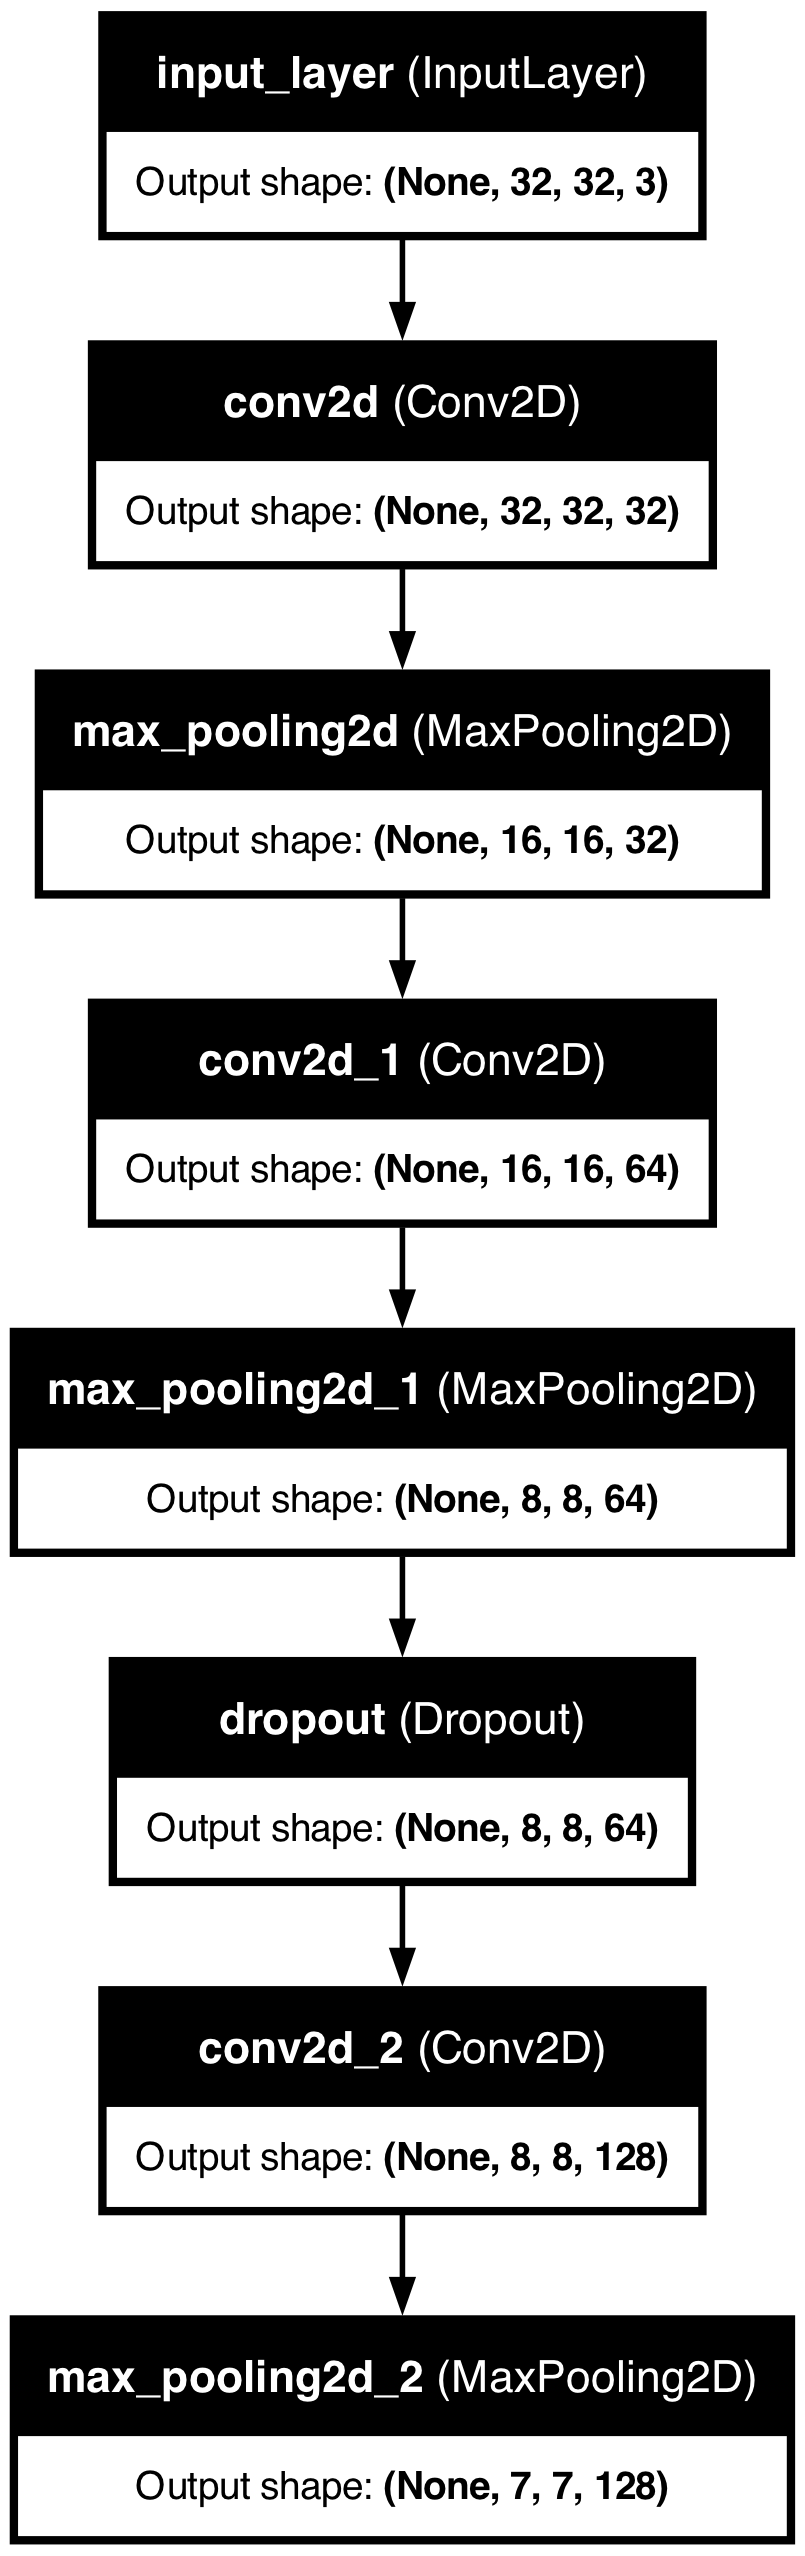

In [4]:
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu')(x)
outputs = keras.layers.MaxPooling2D((2, 2), strides=1)(x)

backbone = keras.models.Model(inputs=inputs, outputs=outputs)

# Визуализация архитектуры модели 
plot_model(backbone, to_file='model.png', show_shapes=True, show_layer_names=True)

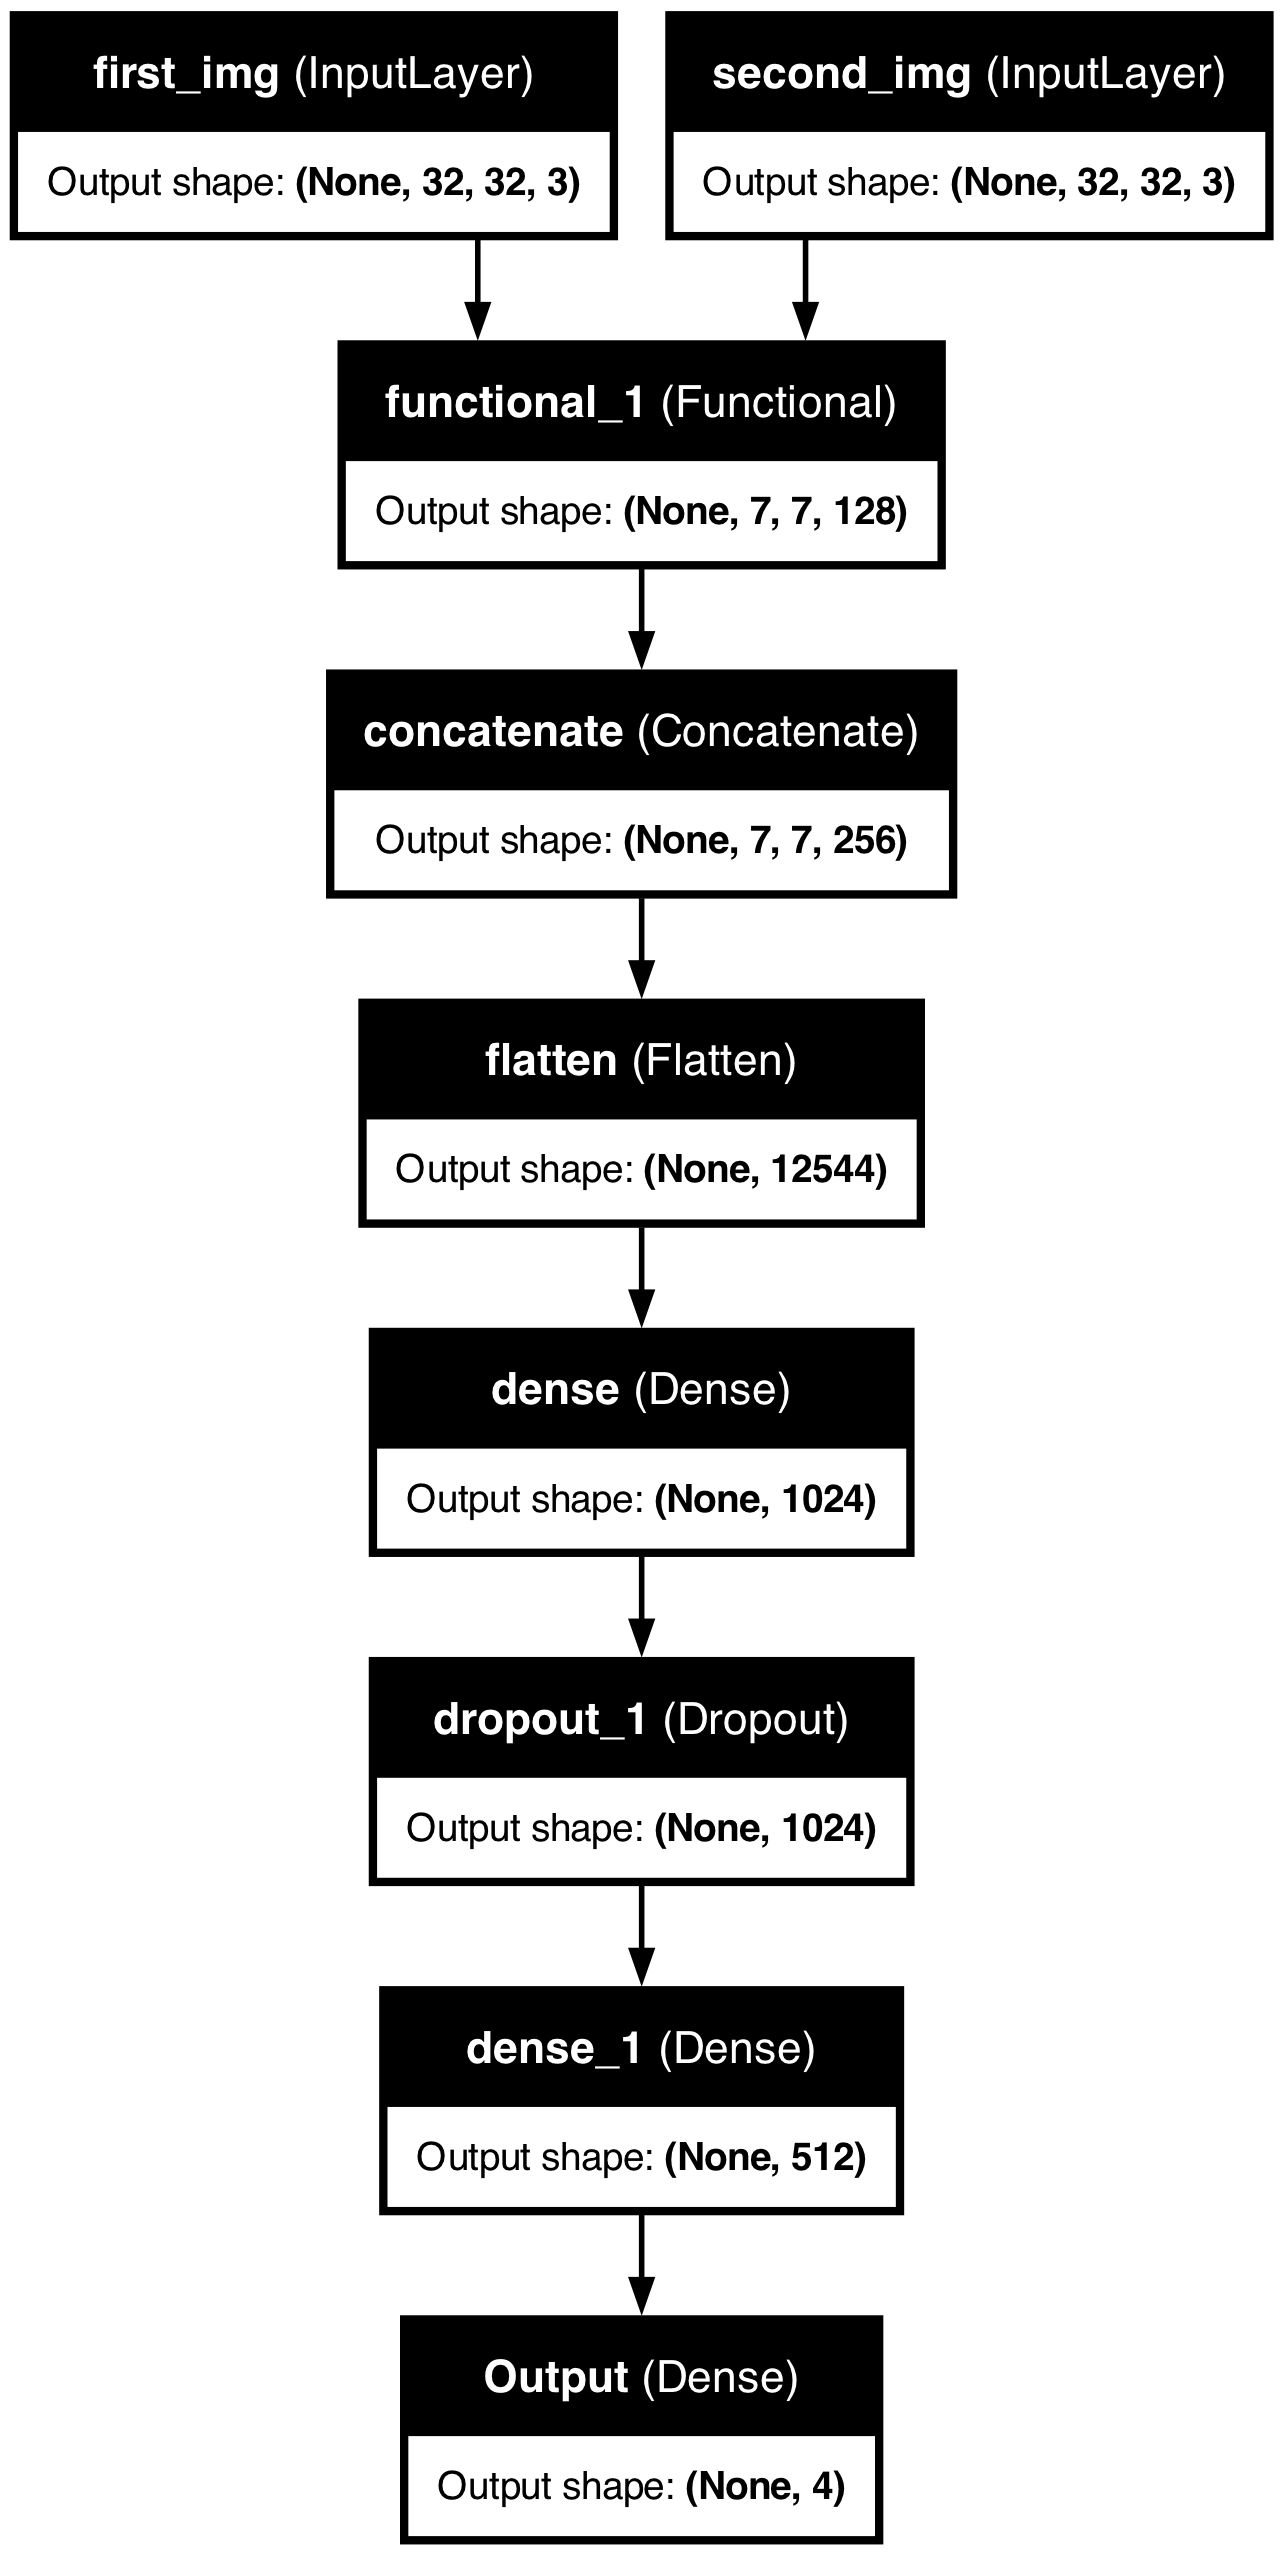

In [6]:
#SSL model
inputs1 = keras.Input(shape = (32,32,3), name='first_img')
inputs2 = keras.Input(shape = (32,32,3), name='second_img')
backbone1 = backbone(inputs1)
backbone2 = backbone(inputs2)
inputs = keras.layers.Concatenate()([backbone1, backbone2])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(4, activation='softmax', name='Output')(x)

ssl_model = keras.models.Model(inputs = [inputs1, inputs2], outputs = outputs)

plot_model(ssl_model, to_file='ssl_model.png', show_shapes=True, show_layer_names=True)

In [7]:
ssl_model.compile(keras.optimizers.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), keras.metrics.Precision(), keras.metrics.Recall()])

train_data = {'first_img': train_first, 'second_img': train_second}
valid_data = {'first_img': valid_first, 'second_img': valid_second}

ssl_model.fit({'first_img':train_first, 'second_img':train_second},  train_outputs, 
          validation_data=({'first_img':valid_first, 'second_img':valid_second},  valid_outputs),
          batch_size=256, epochs=25)

Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - f1_score: 0.3581 - loss: 1.3229 - precision: 0.4927 - recall: 0.0844 - val_f1_score: 0.6527 - val_loss: 0.8844 - val_precision: 0.7745 - val_recall: 0.4790
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - f1_score: 0.6531 - loss: 0.8565 - precision: 0.7408 - recall: 0.5373 - val_f1_score: 0.7006 - val_loss: 0.7555 - val_precision: 0.8017 - val_recall: 0.5965
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - f1_score: 0.7036 - loss: 0.7365 - precision: 0.7750 - recall: 0.6191 - val_f1_score: 0.7390 - val_loss: 0.6696 - val_precision: 0.8094 - val_recall: 0.6520
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - f1_score: 0.7372 - loss: 0.6619 - precision: 0.7980 - recall: 0.6674 - val_f1_score: 0.7458 - val_loss: 0.6423 - val_precision: 0.8088 - val_recall: 0.6745
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 270ms/step - f1_score: 0.7594 - loss: 0.6120 - precision: 0.8150 - recall: 0.6974 - val_f1_score: 0.7824

In [8]:
weights_dir = 'Weights'

if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

backbone.save_weights(os.path.join(weights_dir, 'backbone.weights.h5'))

print("Weights structure of the backbone model:")
for weight in backbone.weights:
    print(weight)

Weights structure of the backbone model:
<KerasVariable shape=(3, 3, 3, 32), dtype=float32, path=conv2d/kernel>
<KerasVariable shape=(32,), dtype=float32, path=conv2d/bias>
<KerasVariable shape=(3, 3, 32, 64), dtype=float32, path=conv2d_1/kernel>
<KerasVariable shape=(64,), dtype=float32, path=conv2d_1/bias>
<KerasVariable shape=(2, 2, 64, 128), dtype=float32, path=conv2d_2/kernel>
<KerasVariable shape=(128,), dtype=float32, path=conv2d_2/bias>


In [9]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

X_dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
y_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)
dataset_train = tf.data.Dataset.zip((X_dataset_train, y_dataset_train))

X_dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_dataset_valid = tf.data.Dataset.from_tensor_slices(y_valid)
dataset_valid = tf.data.Dataset.zip((X_dataset_valid, y_dataset_valid))

dataset_train = dataset_train.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
X_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
y_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)
dataset_test = tf.data.Dataset.zip((X_dataset_test, y_dataset_test))
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

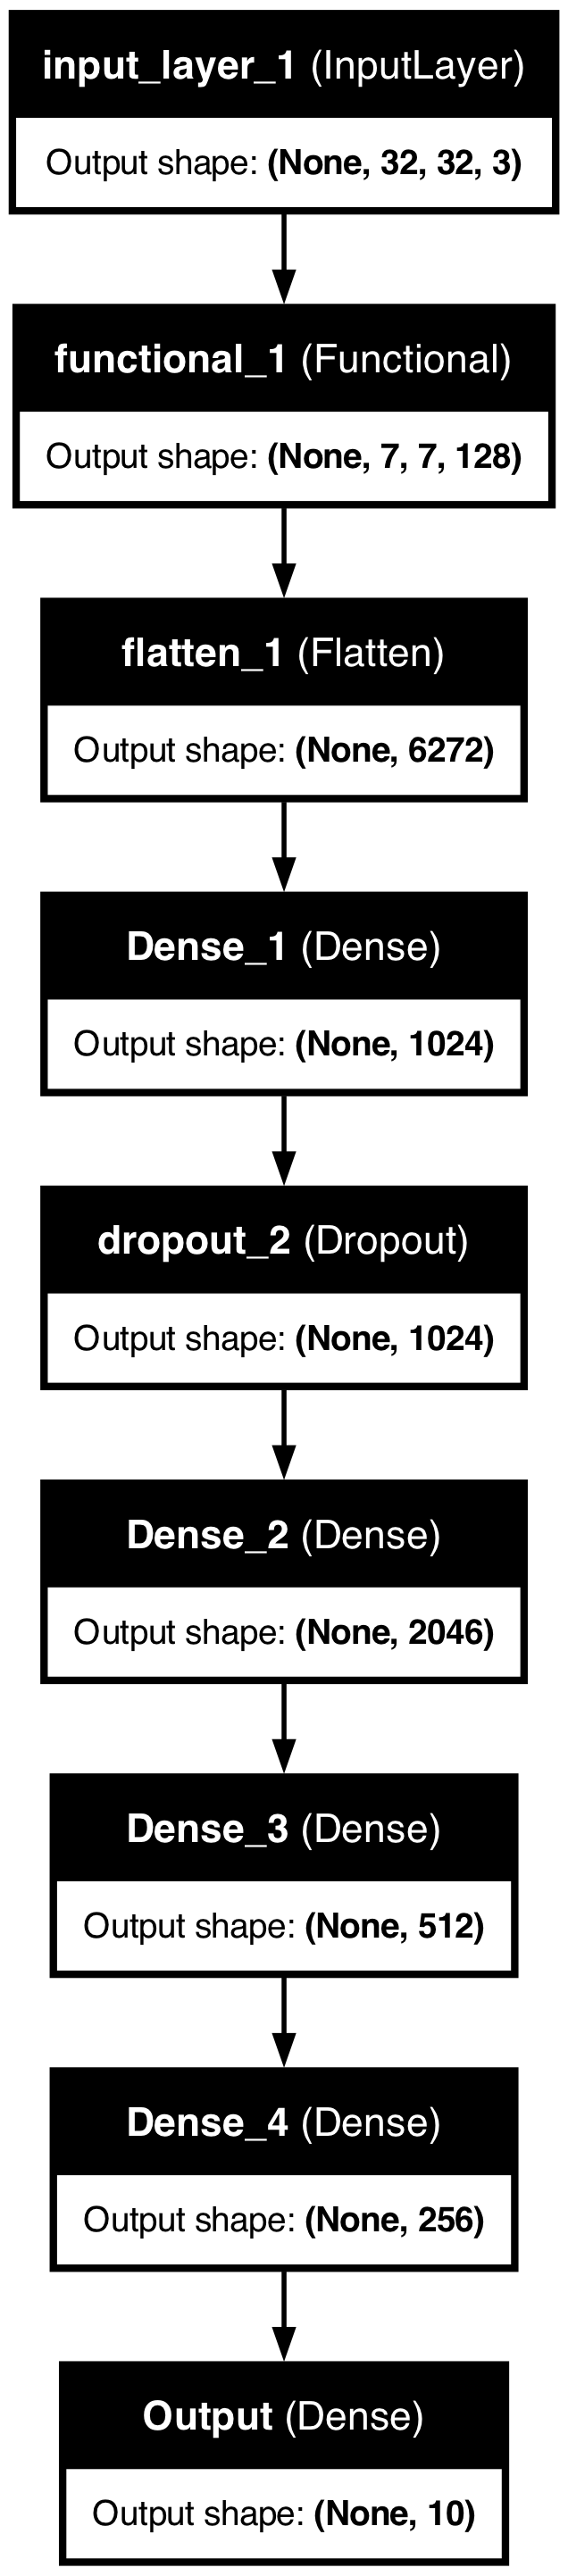

In [10]:
# Expirement 1 обучение на всем датасете

backbone.load_weights('Weights/backbone.weights.h5')

inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

model_1 = keras.models.Model(inputs = inputs, outputs = output)

plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [11]:
model_1.compile(keras.optimizers.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_1'), 
                       keras.metrics.Recall(name='recall_1')])

learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_1")

history_1 = model_1.fit(dataset_train, validation_data=dataset_valid, 
                    epochs=50, callbacks=[learn_rate_red, early_stop, tensorboard])

eval_hist_1 = model_1.evaluate(dataset_test)

print(f"Eval_loss = {eval_hist_1[0]:.4f} \nEval_f1 = {eval_hist_1[1]:.4f} \nEval_precision = {eval_hist_1[2]:.4f} \nEval_recall = {eval_hist_1[3]:.4f}")

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 174ms/step - f1_score: 0.3576 - loss: 1.7120 - precision_1: 0.5782 - recall_1: 0.1525 - val_f1_score: 0.5930 - val_loss: 1.1576 - val_precision_1: 0.7794 - val_recall_1: 0.3855 - learning_rate: 5.0000e-04
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - f1_score: 0.6014 - loss: 1.1095 - precision_1: 0.7437 - recall_1: 0.4579 - val_f1_score: 0.6523 - val_loss: 0.9833 - val_precision_1: 0.7914 - val_recall_1: 0.5117 - learning_rate: 5.0000e-04
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - f1_score: 0.6633 - loss: 0.9454 - precision_1: 0.7742 - recall_1: 0.5494 - val_f1_score: 0.6822 - val_loss: 0.9091 - val_precision_1: 0.7852 - val_recall_1: 0.5850 - learning_rate: 5.0000e-04
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 174ms/step - f1_score: 0.7053 - loss: 0.8285 - precision_1: 0.8046 - recall_1: 0.6121 - val_f1_score: 0.7091 - val_loss: 0.8291 - val_precision_1: 0.7980 - val_recall_1: 0.6209 - learning_rate: 5.0000e-04
Epoc

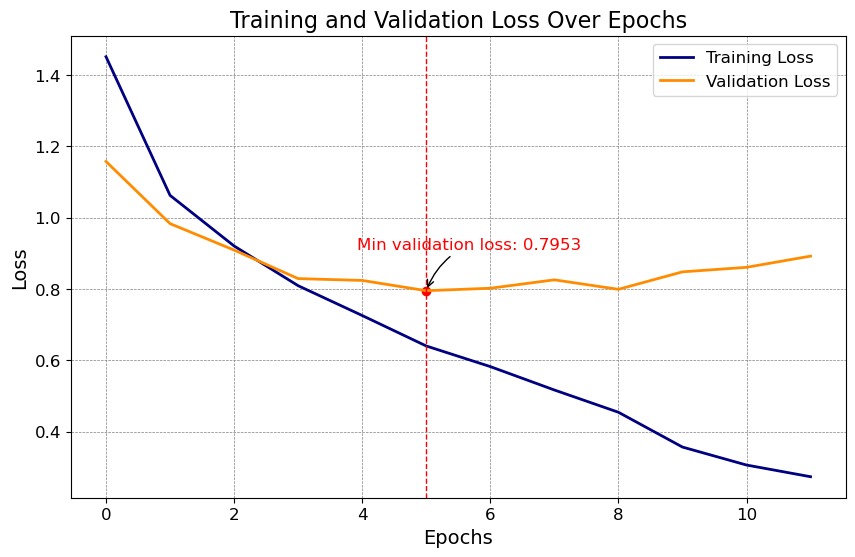

In [12]:
history_df = pd.DataFrame(history_1.history)

plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss', color='navy', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

min_val_loss_idx = history_df['val_loss'].idxmin() 
min_val_loss = history_df['val_loss'].min() 
plt.axvline(x=min_val_loss_idx, linestyle='--', color='red', linewidth=1, label='Lowest Validation Loss')
plt.scatter(min_val_loss_idx, min_val_loss, color='red') 

plt.annotate(f'Min validation loss: {min_val_loss:.4f}',
             xy=(min_val_loss_idx, min_val_loss),
             xycoords='data',
             xytext=(-50, 30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='red')

plt.show()

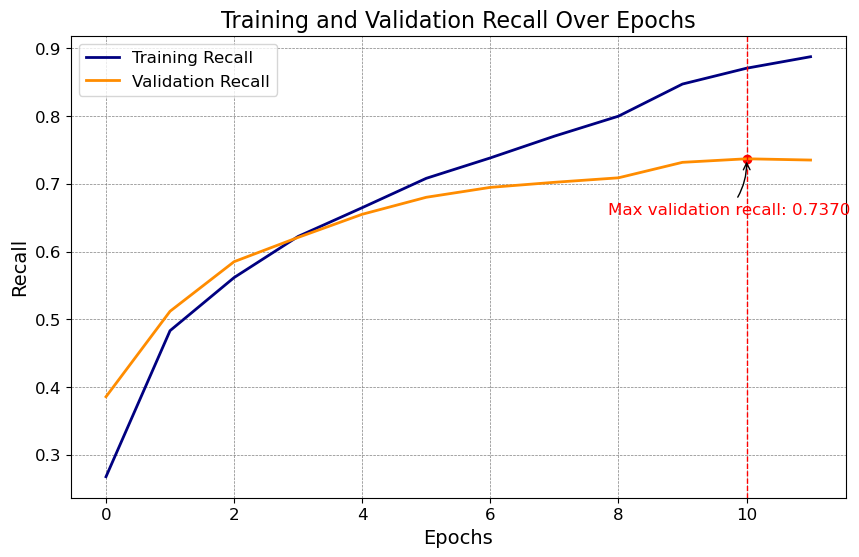

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['recall_1'], label='Training Recall', color='navy', linewidth=2)
plt.plot(history_df['val_recall_1'], label='Validation Recall', color='darkorange', linewidth=2)
plt.title('Training and Validation Recall Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)
max_val_recall_idx = history_df['val_recall_1'].idxmax() 
max_val_recall = history_df['val_recall_1'].max() 
plt.axvline(x=max_val_recall_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Recall')
plt.scatter(max_val_recall_idx, max_val_recall, color='red')

plt.annotate(f'Max validation recall: {max_val_recall:.4f}',
             xy=(max_val_recall_idx, max_val_recall),
             xycoords='data',
             xytext=(-100, -40),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='red')

plt.show()

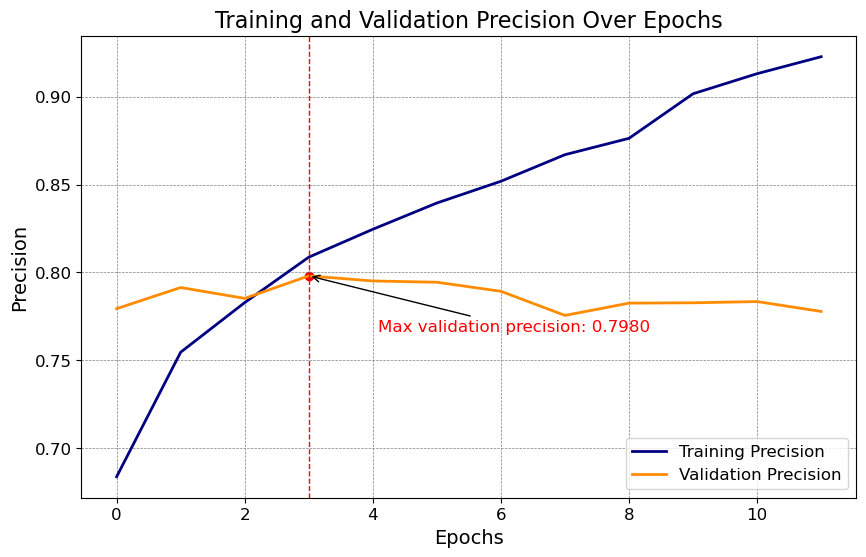

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['precision_1'], label='Training Precision', color='navy', linewidth=2)
plt.plot(history_df['val_precision_1'], label='Validation Precision', color='darkorange', linewidth=2)
plt.title('Training and Validation Precision Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_precision_idx = history_df['val_precision_1'].idxmax()
max_val_precision = history_df['val_precision_1'].max()
plt.axvline(x=max_val_precision_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Precision')
plt.scatter(max_val_precision_idx, max_val_precision, color='red')

plt.annotate(f'Max validation precision: {max_val_precision:.4f}',
             xy=(max_val_precision_idx, max_val_precision),
             xycoords='data',
             xytext=(50, -40),  
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
             fontsize=12,
             color='red')

plt.show()

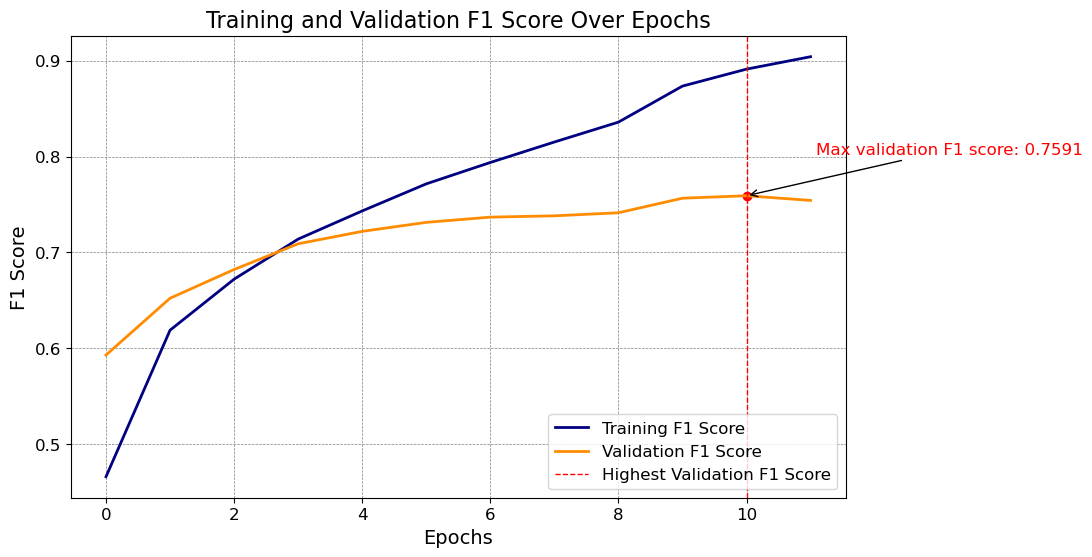

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['f1_score'], label='Training F1 Score', color='navy', linewidth=2)
plt.plot(history_df['val_f1_score'], label='Validation F1 Score', color='darkorange', linewidth=2)
plt.title('Training and Validation F1 Score Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_f1_score_idx = history_df['val_f1_score'].idxmax()
max_val_f1_score = history_df['val_f1_score'].max()
plt.axvline(x=max_val_f1_score_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation F1 Score')
plt.scatter(max_val_f1_score_idx, max_val_f1_score, color='red')

plt.annotate(f'Max validation F1 score: {max_val_f1_score:.4f}',
            xy=(max_val_f1_score_idx, max_val_f1_score),
            xycoords='data',
            xytext=(50, 30),  
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.legend(loc="lower right", fontsize=12)  

plt.show()

In [16]:
preds = model_1.predict(X_test)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))
print(history_df.keys())

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       208
           1       0.89      0.86      0.88       189
           2       0.76      0.59      0.66       199
           3       0.55      0.64      0.60       208
           4       0.73      0.72      0.72       196
           5       0.60      0.74      0.66       202
           6       0.85      0.79      0.82       214
           7       0.86      0.83      0.85       199
           8       0.83      0.86      0.84       194
           9       0.77      0.86      0.82       191

    accuracy                           0.76      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.77      0.76      0.76      2000

Index(['f1_score', 'loss', 'precision_1', 'recall_1', 'val_f1_score',
       'val_loss', 'val_precision_1', 'val_recall_1', 'learning_rate'],
      dtype='object')


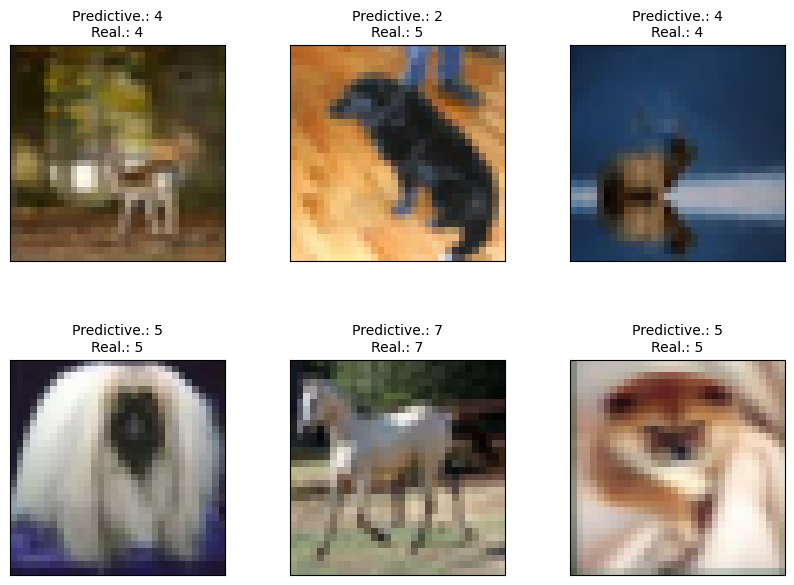

In [17]:
h, w = (2, 3)
fig, axs = plt.subplots(h, w, figsize=(10, 7)) 

plt.subplots_adjust(hspace=0.4, wspace=0.3) 

for i in range(h):
    for j in range(w):
        num = np.random.randint(len(X_test))  
        ax = axs[i, j]
        ax.imshow(X_test[num])  
        predicted_class = str(preds[num])  
        real_class = str(y_test_idx[num])  
        
        ax.set_title(f'Predictive.: {predicted_class}\nReal.: {real_class}', fontsize=10)  
        ax.set(xticks=[], yticks=[]) 

plt.show()

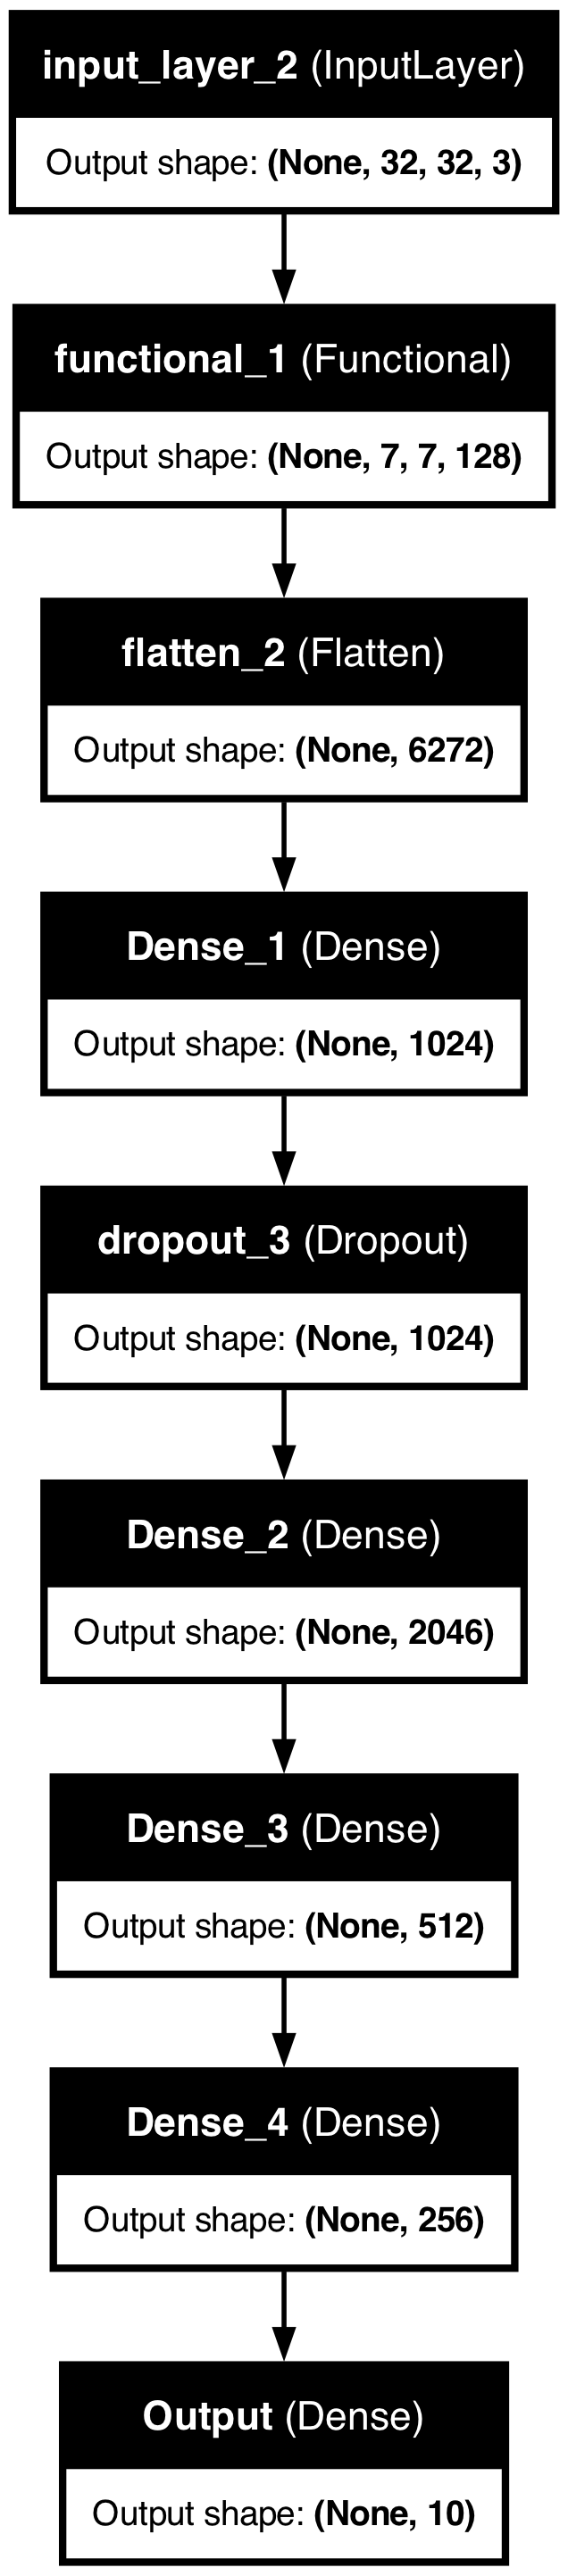

In [18]:
# Exp 2 Эксперимент с предобученным бэкбоном и 50% датасетом

dataset_train_2 = dataset_train.shard(num_shards=2, index=0)
len(dataset_train_2)*256
backbone.load_weights('Weights/backbone.weights.h5')
backbone.weights

inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

model_2 = keras.models.Model(inputs = inputs, outputs = output)

plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [19]:
model_2.compile(keras.optimizers.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_2'), 
                       keras.metrics.Recall(name='recall_2')])
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_2")

history_2 = model_2.fit(dataset_train_2, validation_data=dataset_valid, 
                    epochs=45, callbacks=[learn_rate_red, early_stop, tensorboard])

eval_hist_2 = model_2.evaluate(dataset_test)

print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_2[0], 
                                                                                      eval_hist_2[1], 
                                                                                      eval_hist_2[2],
                                                                                      eval_hist_2[3]))

Epoch 1/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - f1_score: 0.2771 - loss: 1.8874 - precision_2: 0.5109 - recall_2: 0.0818 - val_f1_score: 0.5179 - val_loss: 1.2914 - val_precision_2: 0.7059 - val_recall_2: 0.3264 - learning_rate: 5.0000e-04
Epoch 2/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - f1_score: 0.5408 - loss: 1.2619 - precision_2: 0.7052 - recall_2: 0.3608 - val_f1_score: 0.5892 - val_loss: 1.1181 - val_precision_2: 0.7605 - val_recall_2: 0.4227 - learning_rate: 5.0000e-04
Epoch 3/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - f1_score: 0.5962 - loss: 1.1086 - precision_2: 0.7396 - recall_2: 0.4539 - val_f1_score: 0.6387 - val_loss: 1.0386 - val_precision_2: 0.7735 - val_recall_2: 0.4876 - learning_rate: 5.0000e-04
Epoch 4/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - f1_score: 0.6442 - loss: 0.9991 - precision_2: 0.7654 - recall_2: 0.5226 - val_f1_score: 0.6587 - val_loss: 0.9608 - val_precision_2: 0.7819 - val_recall_2: 0.5360 - learning_rate: 5.0000e-04
Epoch 5/45
9

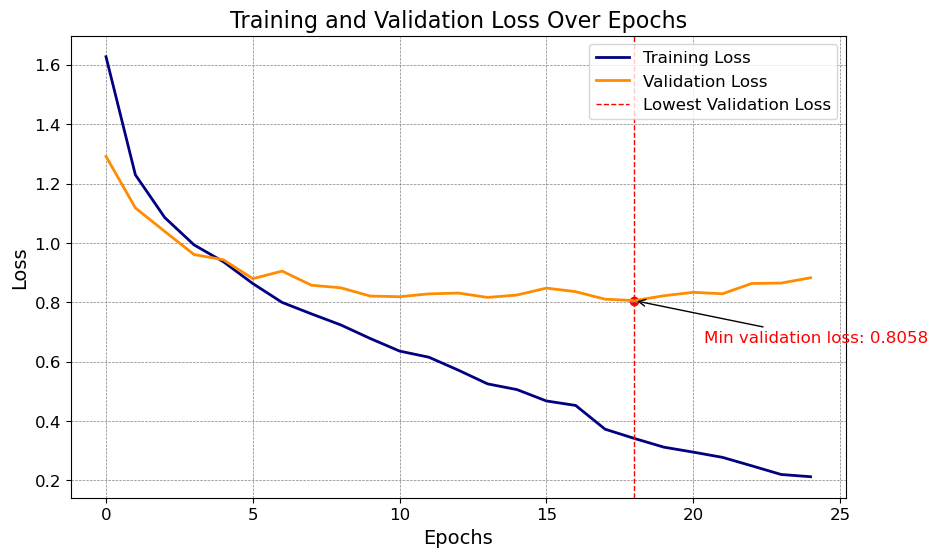

Index(['f1_score', 'loss', 'precision_2', 'recall_2', 'val_f1_score',
       'val_loss', 'val_precision_2', 'val_recall_2', 'learning_rate'],
      dtype='object')


In [20]:
history_df = pd.DataFrame(history_2.history) 
plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss', color='navy', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

min_val_loss_idx = history_df['val_loss'].idxmin()
min_val_loss = history_df['val_loss'].min()
plt.axvline(x=min_val_loss_idx, linestyle='--', color='red', linewidth=1, label='Lowest Validation Loss')
plt.scatter(min_val_loss_idx, min_val_loss, color='red')

plt.annotate(f'Min validation loss: {min_val_loss:.4f}',
            xy=(min_val_loss_idx, min_val_loss),
            xycoords='data',
            xytext=(50, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.legend(loc="upper right", fontsize=12)

plt.show()
print(history_df.keys())

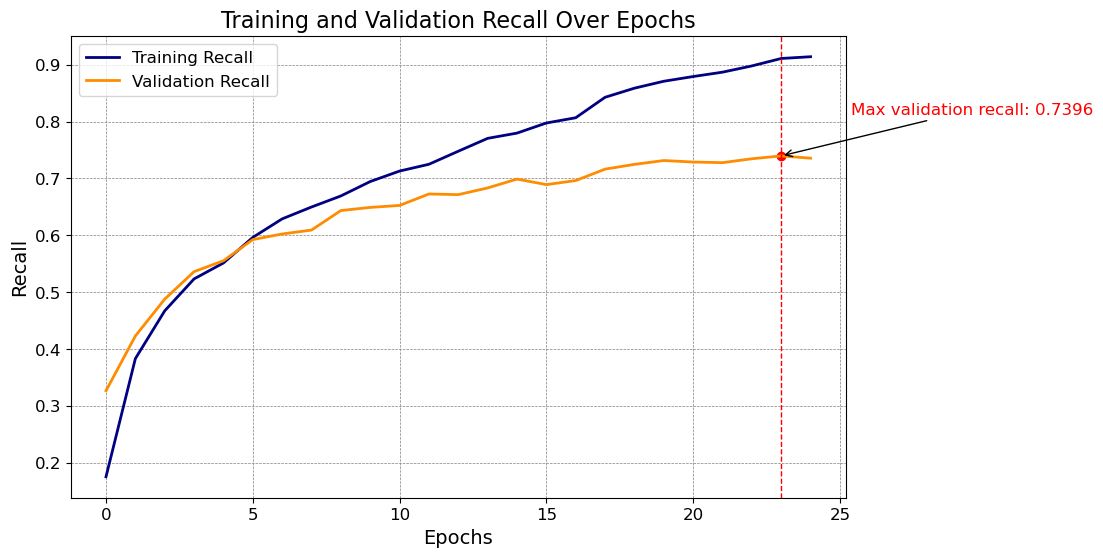

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['recall_2'], label='Training Recall', color='navy', linewidth=2)
plt.plot(history_df['val_recall_2'], label='Validation Recall', color='darkorange', linewidth=2)
plt.title('Training and Validation Recall Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_recall_idx = history_df['val_recall_2'].idxmax()
max_val_recall = history_df['val_recall_2'].max()
plt.axvline(x=max_val_recall_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Recall')
plt.scatter(max_val_recall_idx, max_val_recall, color='red')

plt.annotate(f'Max validation recall: {max_val_recall:.4f}',
            xy=(max_val_recall_idx, max_val_recall),
            xycoords='data',
            xytext=(50, 30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.show()

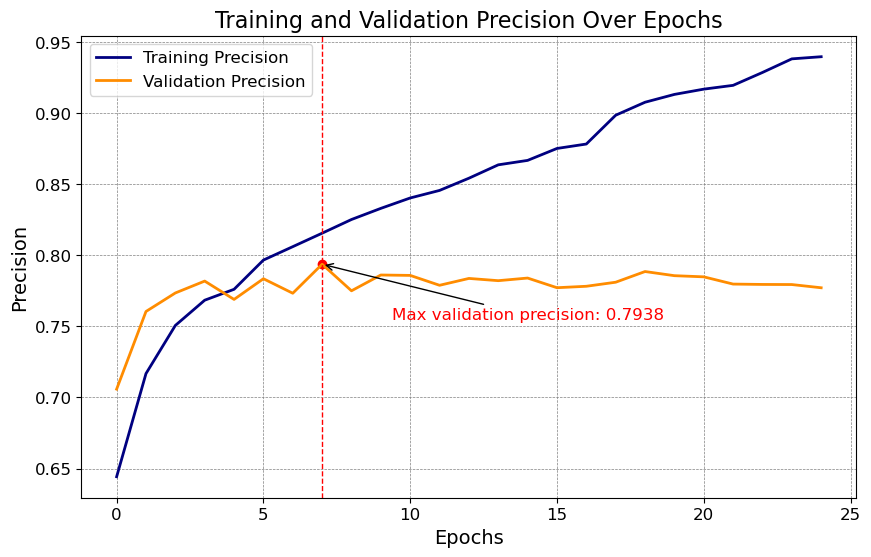

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['precision_2'], label='Training Precision', color='navy', linewidth=2)
plt.plot(history_df['val_precision_2'], label='Validation Precision', color='darkorange', linewidth=2)
plt.title('Training and Validation Precision Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_precision_idx = history_df['val_precision_2'].idxmax()
max_val_precision = history_df['val_precision_2'].max()
plt.axvline(x=max_val_precision_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Precision')
plt.scatter(max_val_precision_idx, max_val_precision, color='red')

plt.annotate(f'Max validation precision: {max_val_precision:.4f}',
             xy=(max_val_precision_idx, max_val_precision),
             xycoords='data',
             xytext=(50, -40),  
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
             fontsize=12,
             color='red')

plt.show()

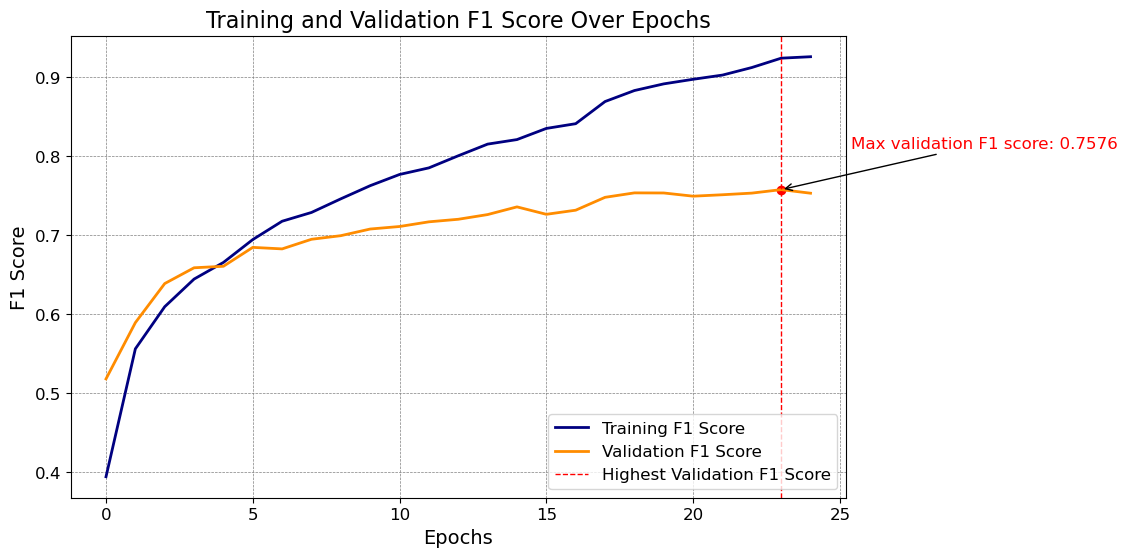

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['f1_score'], label='Training F1 Score', color='navy', linewidth=2)
plt.plot(history_df['val_f1_score'], label='Validation F1 Score', color='darkorange', linewidth=2)
plt.title('Training and Validation F1 Score Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_f1_score_idx = history_df['val_f1_score'].idxmax()
max_val_f1_score = history_df['val_f1_score'].max()
plt.axvline(x=max_val_f1_score_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation F1 Score')
plt.scatter(max_val_f1_score_idx, max_val_f1_score, color='red')

plt.annotate(f'Max validation F1 score: {max_val_f1_score:.4f}',
            xy=(max_val_f1_score_idx, max_val_f1_score),
            xycoords='data',
            xytext=(50, 30),  
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.legend(loc="lower right", fontsize=12)  

plt.show()

In [24]:
preds = model_2.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       208
           1       0.88      0.85      0.87       189
           2       0.72      0.68      0.70       199
           3       0.57      0.59      0.58       208
           4       0.75      0.74      0.74       196
           5       0.62      0.69      0.65       202
           6       0.87      0.80      0.84       214
           7       0.87      0.84      0.85       199
           8       0.83      0.89      0.86       194
           9       0.82      0.86      0.84       191

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



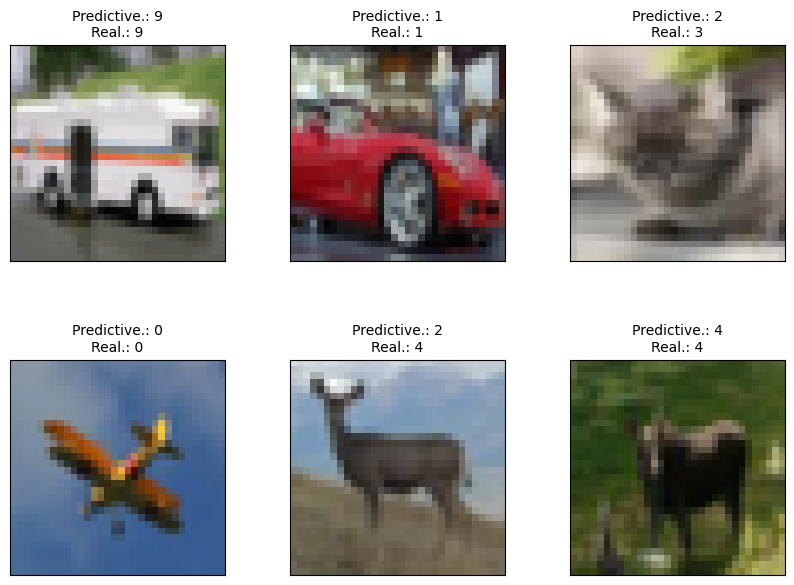

In [25]:
h, w = (2, 3)
fig, axs = plt.subplots(h, w, figsize=(10, 7)) 

plt.subplots_adjust(hspace=0.4, wspace=0.3) 

for i in range(h):
    for j in range(w):
        num = np.random.randint(len(X_test))  
        ax = axs[i, j]
        ax.imshow(X_test[num])  
        predicted_class = str(preds[num])  
        real_class = str(y_test_idx[num])  
        
        ax.set_title(f'Predictive.: {predicted_class}\nReal.: {real_class}', fontsize=10)  
        ax.set(xticks=[], yticks=[]) 

plt.show()

In [26]:
# Exp 3 Эксперимент с предобученным бэкбоном и 10% датасетом

dataset_train_3 = dataset_train.shard(num_shards=10, index=0)

len(dataset_train_3)*256

backbone.load_weights('Weights/backbone.weights.h5')

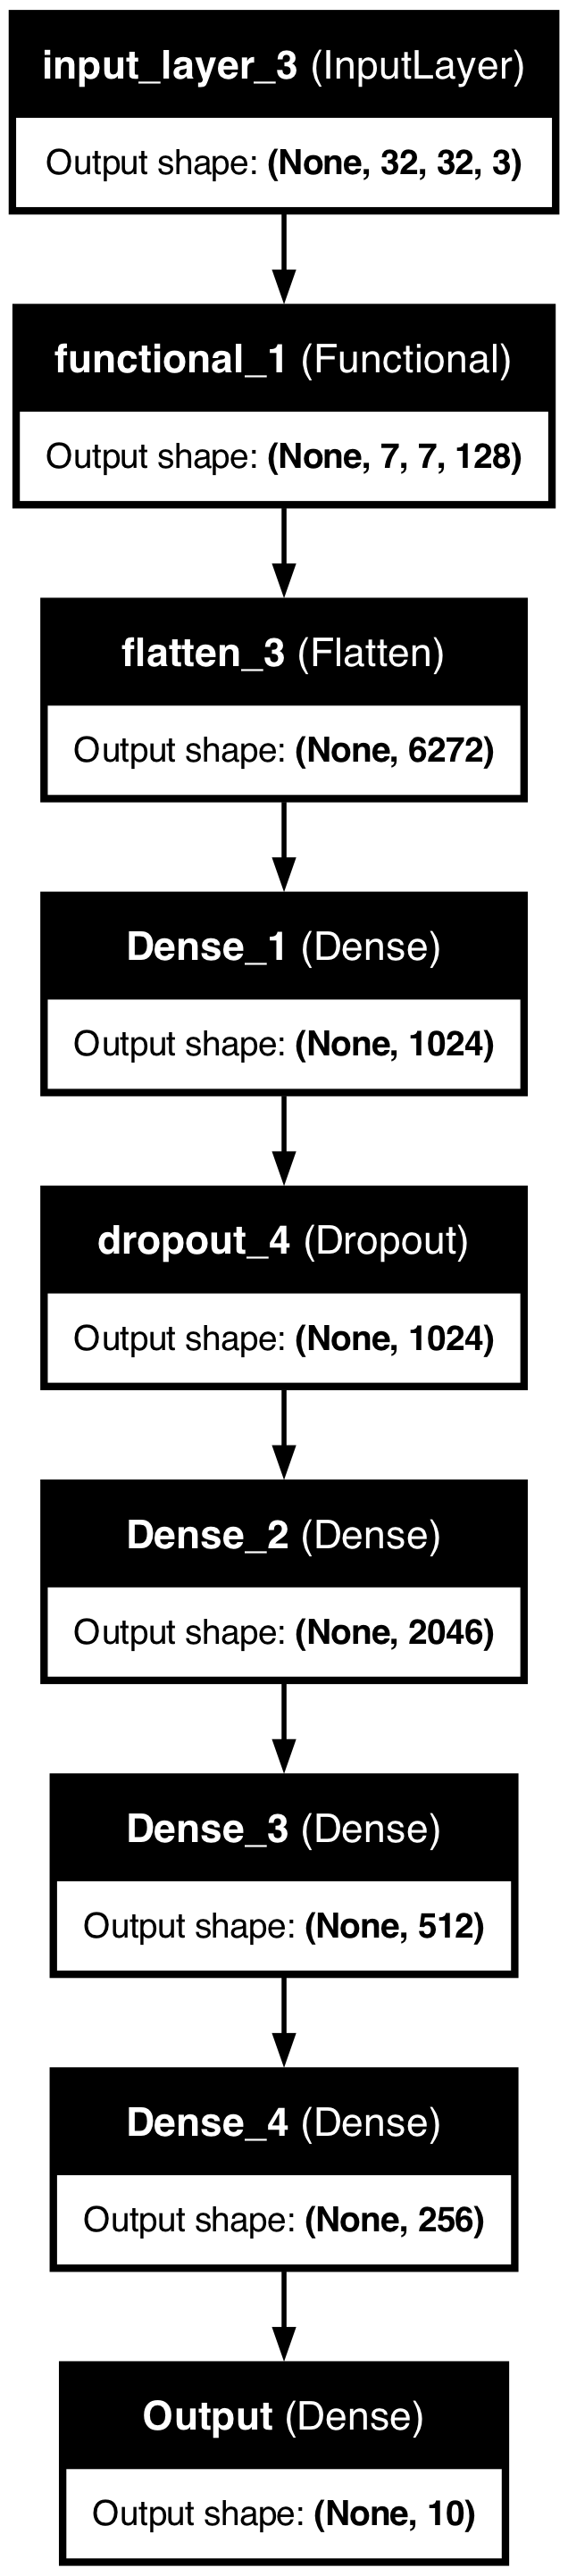

In [27]:
inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

model_3 = keras.models.Model(inputs = inputs, outputs = output)
plot_model(model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

In [28]:
model_3.compile(keras.optimizers.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_3'), 
                       keras.metrics.Recall(name='recall_3')])

learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_3")

history_3 = model_3.fit(dataset_train_3, validation_data=dataset_valid, 
                    epochs=45, callbacks=[learn_rate_red, early_stop, tensorboard])

eval_hist_3 = model_3.evaluate(dataset_test)

print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_3[0], 
                                                                                      eval_hist_3[1], 
                                                                                      eval_hist_3[2],
                                                                                      eval_hist_3[3]))

Epoch 1/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - f1_score: 0.1176 - loss: 2.2279 - precision_3: 0.2730 - recall_3: 0.0035 - val_f1_score: 0.3059 - val_loss: 1.8230 - val_precision_3: 0.6651 - val_recall_3: 0.0176 - learning_rate: 5.0000e-04
Epoch 2/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - f1_score: 0.3435 - loss: 1.7681 - precision_3: 0.5530 - recall_3: 0.0735 - val_f1_score: 0.4219 - val_loss: 1.5720 - val_precision_3: 0.6884 - val_recall_3: 0.0989 - learning_rate: 5.0000e-04
Epoch 3/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - f1_score: 0.4091 - loss: 1.5697 - precision_3: 0.6236 - recall_3: 0.1589 - val_f1_score: 0.4646 - val_loss: 1.4224 - val_precision_3: 0.6689 - val_recall_3: 0.2490 - learning_rate: 5.0000e-04
Epoch 4/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - f1_score: 0.4875 - loss: 1.3897 - precision_3: 0.6690 - recall_3: 0.2833 - val_f1_score: 0.4827 - val_loss: 1.3818 - val_precision_3: 0.7171 - val_recall_3: 0.2614 - learning_rate: 5.0000e-04
Epoch 5/45
20/20

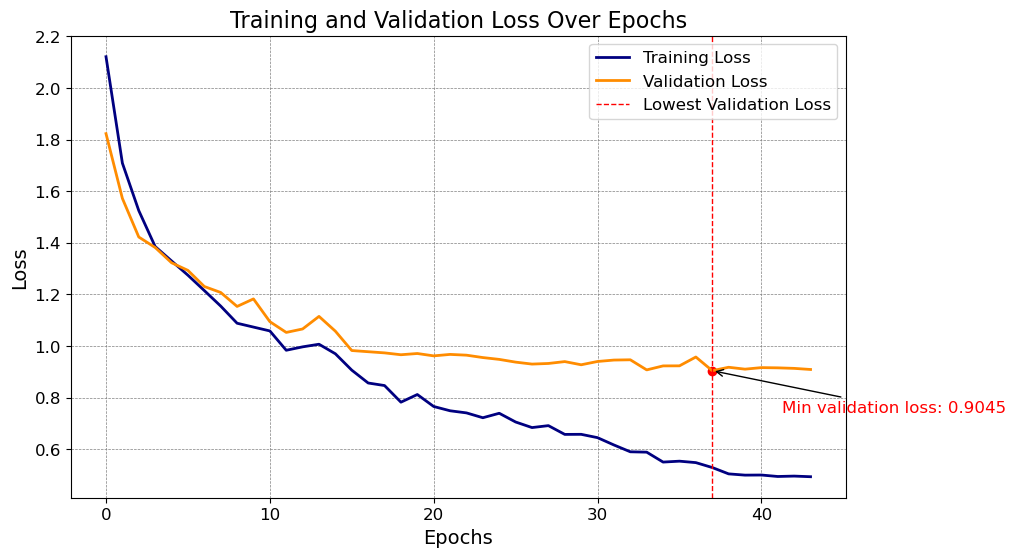

In [29]:
history_df = pd.DataFrame(history_3.history) 
plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss', color='navy', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

min_val_loss_idx = history_df['val_loss'].idxmin()
min_val_loss = history_df['val_loss'].min()
plt.axvline(x=min_val_loss_idx, linestyle='--', color='red', linewidth=1, label='Lowest Validation Loss')
plt.scatter(min_val_loss_idx, min_val_loss, color='red')

plt.annotate(f'Min validation loss: {min_val_loss:.4f}',
            xy=(min_val_loss_idx, min_val_loss),
            xycoords='data',
            xytext=(50, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.legend(loc="upper right", fontsize=12)

plt.show()

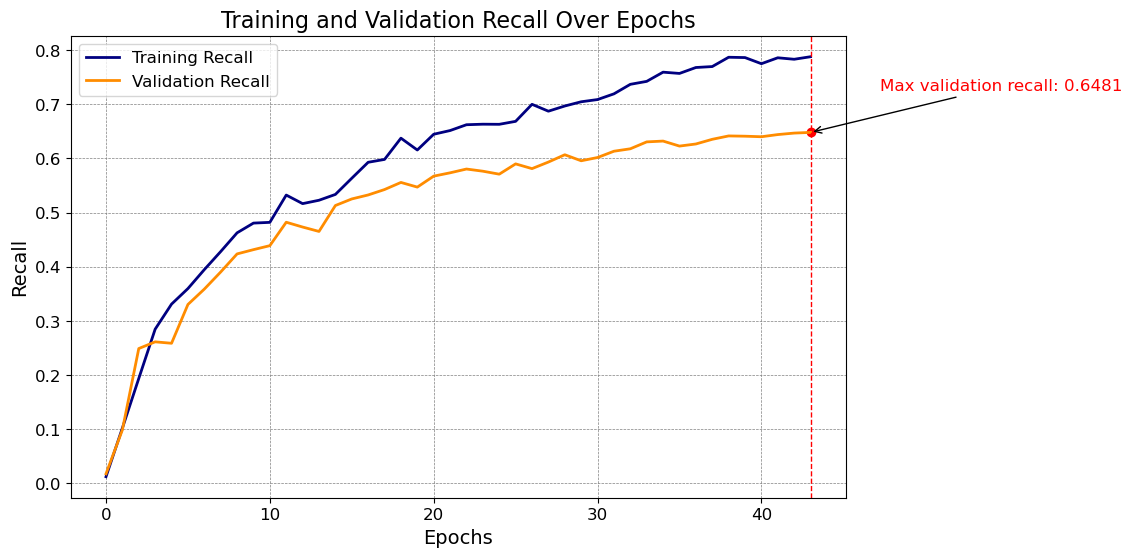

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['recall_3'], label='Training Recall', color='navy', linewidth=2)
plt.plot(history_df['val_recall_3'], label='Validation Recall', color='darkorange', linewidth=2)
plt.title('Training and Validation Recall Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_recall_idx = history_df['val_recall_3'].idxmax()
max_val_recall = history_df['val_recall_3'].max()
plt.axvline(x=max_val_recall_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Recall')
plt.scatter(max_val_recall_idx, max_val_recall, color='red')

plt.annotate(f'Max validation recall: {max_val_recall:.4f}',
            xy=(max_val_recall_idx, max_val_recall),
            xycoords='data',
            xytext=(50, 30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.show()

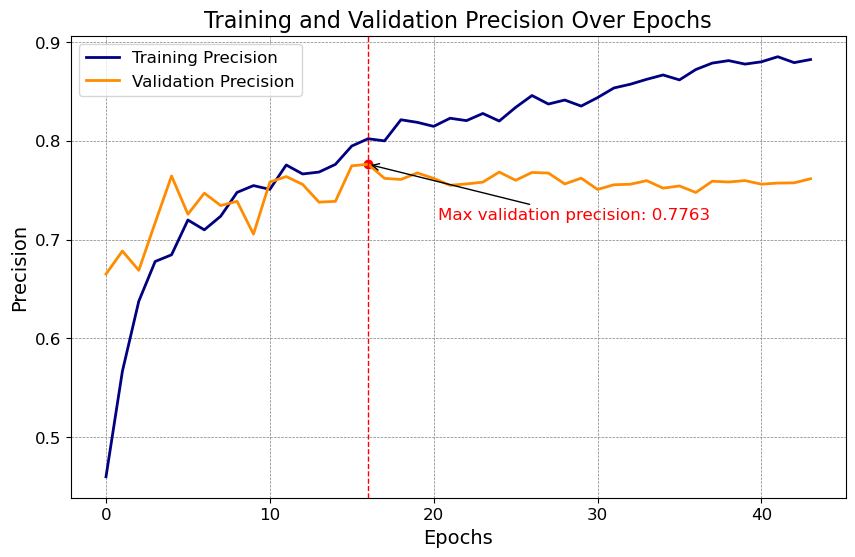

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['precision_3'], label='Training Precision', color='navy', linewidth=2)
plt.plot(history_df['val_precision_3'], label='Validation Precision', color='darkorange', linewidth=2)
plt.title('Training and Validation Precision Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_precision_idx = history_df['val_precision_3'].idxmax()
max_val_precision = history_df['val_precision_3'].max()
plt.axvline(x=max_val_precision_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Precision')
plt.scatter(max_val_precision_idx, max_val_precision, color='red')

plt.annotate(f'Max validation precision: {max_val_precision:.4f}',
             xy=(max_val_precision_idx, max_val_precision),
             xycoords='data',
             xytext=(50, -40), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
             fontsize=12,
             color='red')

plt.show()

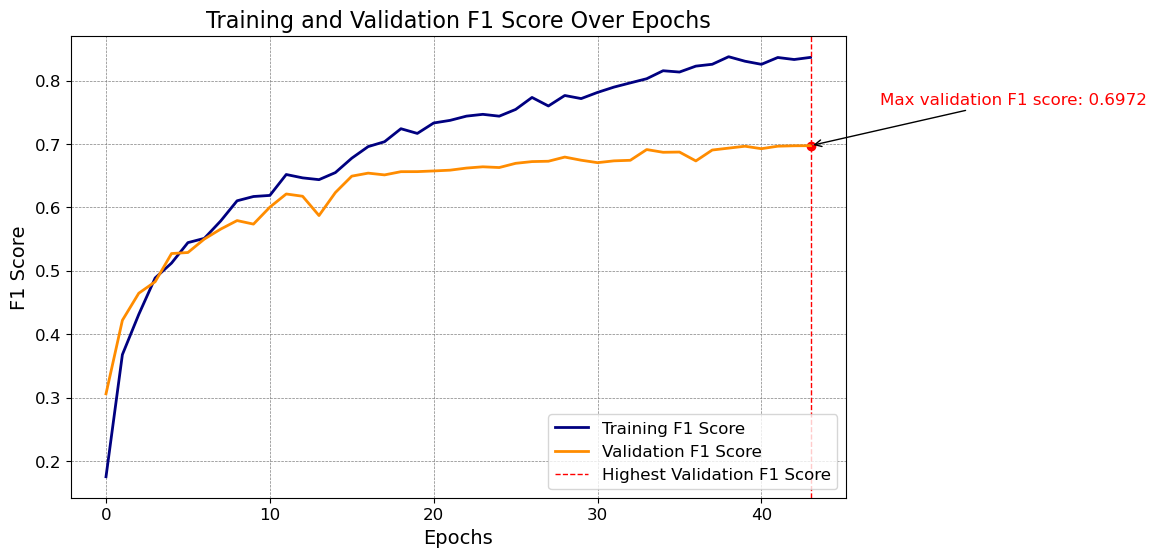

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['f1_score'], label='Training F1 Score', color='navy', linewidth=2)
plt.plot(history_df['val_f1_score'], label='Validation F1 Score', color='darkorange', linewidth=2)
plt.title('Training and Validation F1 Score Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_f1_score_idx = history_df['val_f1_score'].idxmax()
max_val_f1_score = history_df['val_f1_score'].max()
plt.axvline(x=max_val_f1_score_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation F1 Score')
plt.scatter(max_val_f1_score_idx, max_val_f1_score, color='red')

plt.annotate(f'Max validation F1 score: {max_val_f1_score:.4f}',
            xy=(max_val_f1_score_idx, max_val_f1_score),
            xycoords='data',
            xytext=(50, 30),  
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=12,
            color='red')

plt.legend(loc="lower right", fontsize=12)  

plt.show()

In [33]:
preds = model_3.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       208
           1       0.83      0.83      0.83       189
           2       0.68      0.52      0.59       199
           3       0.54      0.48      0.51       208
           4       0.66      0.68      0.67       196
           5       0.59      0.65      0.62       202
           6       0.78      0.84      0.81       214
           7       0.74      0.79      0.77       199
           8       0.85      0.85      0.85       194
           9       0.75      0.82      0.78       191

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



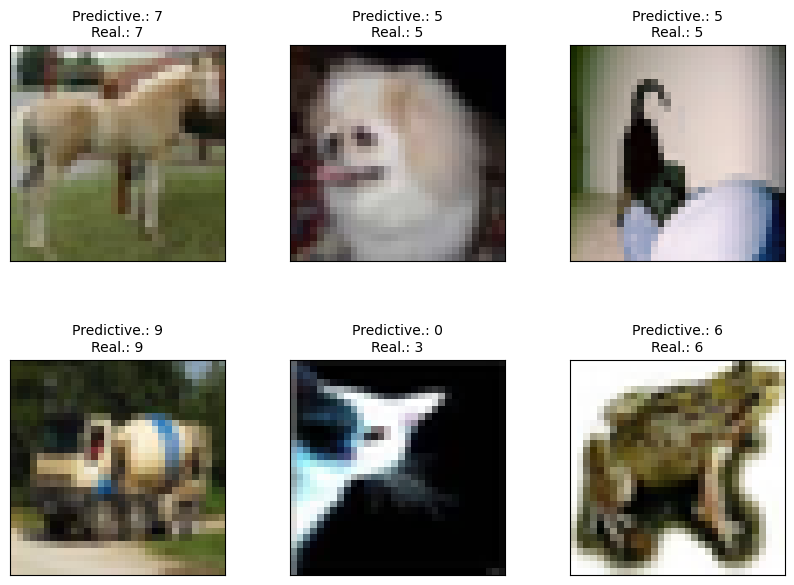

In [34]:
h, w = (2, 3)
fig, axs = plt.subplots(h, w, figsize=(10, 7)) 

plt.subplots_adjust(hspace=0.4, wspace=0.3) 

for i in range(h):
    for j in range(w):
        num = np.random.randint(len(X_test))  
        ax = axs[i, j]
        ax.imshow(X_test[num])  
        predicted_class = str(preds[num])  
        real_class = str(y_test_idx[num])  
        
        ax.set_title(f'Predictive.: {predicted_class}\nReal.: {real_class}', fontsize=10)  
        ax.set(xticks=[], yticks=[]) 

plt.show()